In [14]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import shutil
from utils_functions import scale_array_to_range, plot_imgs_and_masks, save_arr_as_img, create_or_overwrite_dir
from dataset import BrainTissueDataset
from loader import load_BrainTissue_data
from os import listdir
from os.path import isfile, join
from PIL import Image
import configs

# Data exploration

## Read mask and image 

In [15]:
img_path = f"{configs.BASE_PATH}/data/FeTA_1.2.1_BIDS/feta1.2.1/sub-feta001/anat/sub-feta001_T2w.nii.gz"
sr_path = f"{configs.BASE_PATH}/data/FeTA_1.2.1_BIDS/feta1.2.1/derivatives/sub-feta001/anat/sub-feta001_T2w-SR.nii.gz"
seg_path = f"{configs.BASE_PATH}/data/FeTA_1.2.1_BIDS/feta1.2.1/derivatives/sub-feta001/anat/sub-feta001_T2w-SR_dseg.nii.gz"

In [16]:
img = nib.load(img_path)
sr = nib.load(sr_path)
seg = nib.load(seg_path)

img_data = img.get_fdata()
sr_data = sr.get_fdata()
seg_data = seg.get_fdata()

In [17]:
img_data.shape, sr_data.shape, seg_data.shape

((256, 256, 256), (256, 256, 256), (256, 256, 256))

In [18]:
(img_data.min(), img_data.max()), (sr_data.min(), sr_data.max()), (seg_data.min(), seg_data.max())

((0.0, 1588.0), (0.0, 1588.0), (0.0, 7.0))

In [19]:
print(np.unique(img_data))
print(np.unique(sr_data))
print(np.unique(seg_data))

[0.000e+00 1.000e+00 2.000e+00 ... 1.560e+03 1.582e+03 1.588e+03]
[0.000e+00 1.000e+00 2.000e+00 ... 1.560e+03 1.582e+03 1.588e+03]
[0. 1. 2. 3. 4. 5. 6. 7.]


In [20]:
(img_data == sr_data).all() # img and sr are the same data, so next I use only img and seg

True

## Slice images into 2D

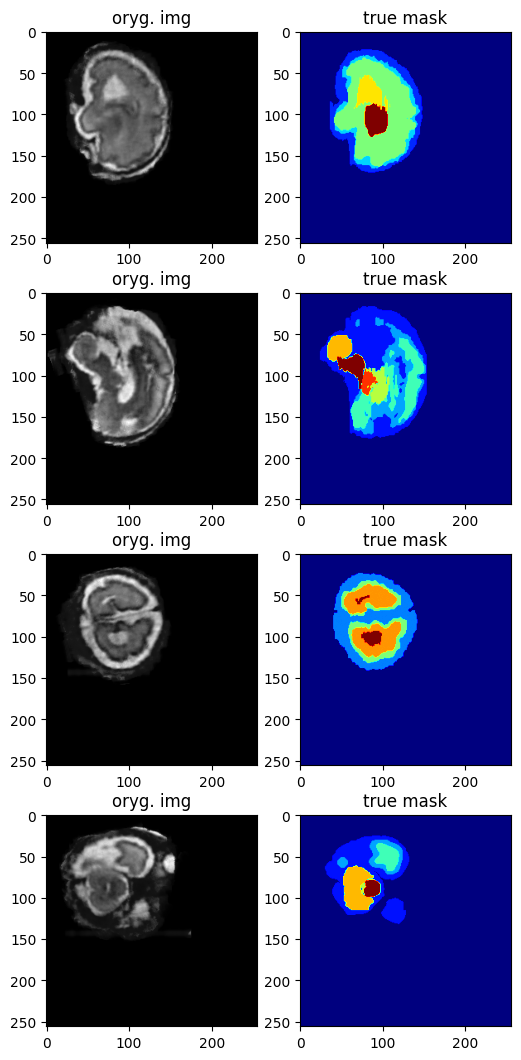

In [8]:
img_slice1 = img_data[50,:,:]
seg_slice1 = seg_data[50,:,:]

img_slice2 = img_data[80,:,:]
seg_slice2 = seg_data[80,:,:]

img_slice3 = img_data[:,50,:]
seg_slice3 = seg_data[:,50,:]

img_slice4 = img_data[:,:,50]
seg_slice4 = seg_data[:,:,50]

plot_imgs_and_masks([img_slice1, img_slice2, img_slice3, img_slice4], [seg_slice1, seg_slice2, seg_slice3, seg_slice4])

# Transform data to 2D slices

### Constants and definitions

In [2]:
SLICE_X = True
SLICE_Y = True
SLICE_Z = True

In [5]:
max_img_idx = 40

img_names = [f'sub-feta{str(img_idx).zfill(configs.SLICE_DECIMATE_IDENTIFIER)}' for img_idx in range(1, max_img_idx+1)]

img_paths = [os.path.join(configs.IMG_DIR_PATH, img_name, 'anat', img_name + "_T2w.nii.gz") for img_name in img_names]
seg_paths = [os.path.join(configs.SEG_DIR_PATH, img_name, 'anat', img_name + "_T2w-SR_dseg.nii.gz") for img_name in img_names]

In [16]:
# define image HOUNSFIELD boundaries based on first 35 images 
mins = []
maxes = []
for img_path in img_paths[0:35]:
    img_data = nib.load(img_path).get_fdata()
    mins.append(np.min(img_data))
    maxes.append(np.max(img_data))

HOUNSFIELD_MIN = np.min(mins)
HOUNSFIELD_MAX = np.max(maxes)

In [17]:
HOUNSFIELD_MIN, HOUNSFIELD_MAX

(0.0, 1833.0)

### Functions

In [85]:
def normalize_img_intensity_range(img_data):
    '''
    Normalize img_data to [0,1]. If values are out of range [HOUNSFIELD_MIN, HOUNSFIELD_MAX], they are first trimmed to this range and then normalized to [0, 1].
    '''
    img_data[img_data < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img_data[img_data > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img_data - HOUNSFIELD_MIN) / (HOUNSFIELD_MAX - HOUNSFIELD_MIN)

In [86]:
def read_img_data_volume(img_path, normalize = False):
    img_data = nib.load(img_path).get_fdata()
    if normalize:
        return normalize_img_intensity_range(img_data)
    else:
        return img_data

In [88]:
def slice_and_save_volume_img(vol, dir_path, image_name, curr_img_range_min, curr_img_range_max):
    (dimx, dimy, dimz) = vol.shape
    cnt = 0

    img_dir_path = os.path.join(dir_path, image_name)
    create_or_overwrite_dir(img_dir_path)
    if SLICE_X:
        x_dir_path = os.path.join(img_dir_path, 'X')
        create_or_overwrite_dir(x_dir_path)
        cnt += dimx
        for i in range(dimx):
            save_arr_as_img(vol[i,:,:], curr_img_range_min, curr_img_range_max, x_dir_path, image_name+f'-slice{str(i).zfill(configs.SLICE_DECIMATE_IDENTIFIER)}_x')

    if SLICE_Y:
        y_dir_path = os.path.join(img_dir_path, 'Y')
        create_or_overwrite_dir(y_dir_path)
        cnt += dimx
        for i in range(dimy):
            save_arr_as_img(vol[:,i,:], curr_img_range_min, curr_img_range_max, y_dir_path, image_name+f'-slice{str(i).zfill(configs.SLICE_DECIMATE_IDENTIFIER)}_y')
   
    if SLICE_Z:
        z_dir_path = os.path.join(img_dir_path, 'Z')
        create_or_overwrite_dir(z_dir_path)
        cnt += dimx
        for i in range(dimz):
            save_arr_as_img(vol[:,:,i], curr_img_range_min, curr_img_range_max, z_dir_path, image_name+f'-slice{str(i).zfill(configs.SLICE_DECIMATE_IDENTIFIER)}_z')

### 2D Slicing

Images are firs scalled to [0, 1] range with HOUNSFIELD_MIN, HOUNSFIELD_MAX trimming. Then, to save them I scale them from [0, 1] to [0, 255] range.

Masks are not scalled initially, they have values from set {0, 1, ..., 7}. To save them I scale the to [0, 255] range. 

In [89]:
for img_name, img_path in zip(img_names, img_paths):
    print(f'sclicing image: {img_name}')
    img_data = read_img_data_volume(img_path, normalize=True)
    slice_and_save_volume_img(img_data, configs.DATA_2D_PATH, img_name, 0, 1)

sclicing image: sub-feta001
sclicing image: sub-feta002
sclicing image: sub-feta003
sclicing image: sub-feta004
sclicing image: sub-feta005
sclicing image: sub-feta006
sclicing image: sub-feta007
sclicing image: sub-feta008
sclicing image: sub-feta009
sclicing image: sub-feta010
sclicing image: sub-feta011
sclicing image: sub-feta012
sclicing image: sub-feta013
sclicing image: sub-feta014
sclicing image: sub-feta015
sclicing image: sub-feta016
sclicing image: sub-feta017
sclicing image: sub-feta018
sclicing image: sub-feta019
sclicing image: sub-feta020
sclicing image: sub-feta021
sclicing image: sub-feta022
sclicing image: sub-feta023
sclicing image: sub-feta024
sclicing image: sub-feta025
sclicing image: sub-feta026
sclicing image: sub-feta027
sclicing image: sub-feta028
sclicing image: sub-feta029
sclicing image: sub-feta030
sclicing image: sub-feta031
sclicing image: sub-feta032
sclicing image: sub-feta033
sclicing image: sub-feta034
sclicing image: sub-feta035
sclicing image: sub-

In [79]:
for img_name, seg_path in zip(img_names, seg_paths):
    print(f'sclicing segmentation mask for image: {img_name}')
    seg_data = read_img_data_volume(seg_path, normalize=False)
    slice_and_save_volume_img(seg_data, configs.DATA_2D_PATH, img_name + 'seg', 0, 7)

sclicing segmentation mask for image: sub-feta001
sclicing segmentation mask for image: sub-feta002
sclicing segmentation mask for image: sub-feta003
sclicing segmentation mask for image: sub-feta004
sclicing segmentation mask for image: sub-feta005
sclicing segmentation mask for image: sub-feta006
sclicing segmentation mask for image: sub-feta007
sclicing segmentation mask for image: sub-feta008
sclicing segmentation mask for image: sub-feta009
sclicing segmentation mask for image: sub-feta010
sclicing segmentation mask for image: sub-feta011
sclicing segmentation mask for image: sub-feta012
sclicing segmentation mask for image: sub-feta013
sclicing segmentation mask for image: sub-feta014
sclicing segmentation mask for image: sub-feta015
sclicing segmentation mask for image: sub-feta016
sclicing segmentation mask for image: sub-feta017
sclicing segmentation mask for image: sub-feta018
sclicing segmentation mask for image: sub-feta019
sclicing segmentation mask for image: sub-feta020


### Check a few image slices and masks with the use of BrainTissueDataset

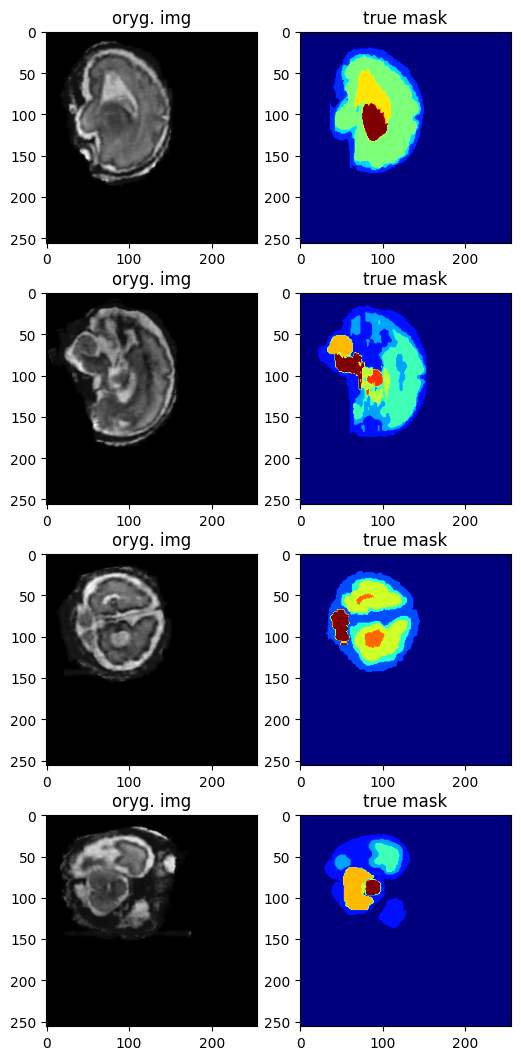

In [21]:
img1, mask1 = BrainTissueDataset(configs.DATA_2D_PATH, 1, 40, 'X').__getitem__(50)
img2, mask2 = BrainTissueDataset(configs.DATA_2D_PATH, 1, 40, 'X').__getitem__(80)
img3, mask3 = BrainTissueDataset(configs.DATA_2D_PATH, 1, 40, 'Y').__getitem__(50)
img4, mask4 = BrainTissueDataset(configs.DATA_2D_PATH, 1, 40, 'Z').__getitem__(50)

imgs = [img1, img2, img3, img4] # tensors in range [0.0, 1.0]
masks = [mask1, mask2, mask3, mask4] # masks in range {0, 1, ..., 7}

imgs = [scale_array_to_range(img.numpy().squeeze(), 0, 1, 0, 255) for img in imgs]
masks = [mask.numpy() for mask in masks]

plot_imgs_and_masks(imgs, masks)

### Removing constant slices

In [31]:
constant_slices_count = 0
for img_name, img_path, seg_path in zip(img_names, img_paths, seg_paths):

    for axis in ['X', 'Y', 'Z']:
        volumne_dir = os.path.join(configs.DATA_2D_PATH, f"{img_name}", axis)
        slice_img_paths = [os.path.join(volumne_dir, f) for f in listdir(volumne_dir) if isfile(join(volumne_dir, f))]
        mask_dir = os.path.join(configs.DATA_2D_PATH, f"{img_name}seg", axis)
        slice_mask_paths = [os.path.join(mask_dir, f) for f in listdir(mask_dir) if isfile(join(mask_dir, f))]
        
        for slice_img_path, slice_mask_path in zip(slice_img_paths, slice_mask_paths):
            x = Image.open(slice_img_path) # pil image in range [0, 255]
            y = Image.open(slice_mask_path)  # pil image in range [0, 255]
            if ( (len(np.unique(x)) == 1) ):
                constant_slices_count+=1
                os.remove(slice_img_path)
                os.remove(slice_mask_path)

print(f'Removed {constant_slices_count} constant slices and their masks')  

Removed 0 constant slices and their masks


### Check a few image slices and masks with the use of BrainTissueDataset

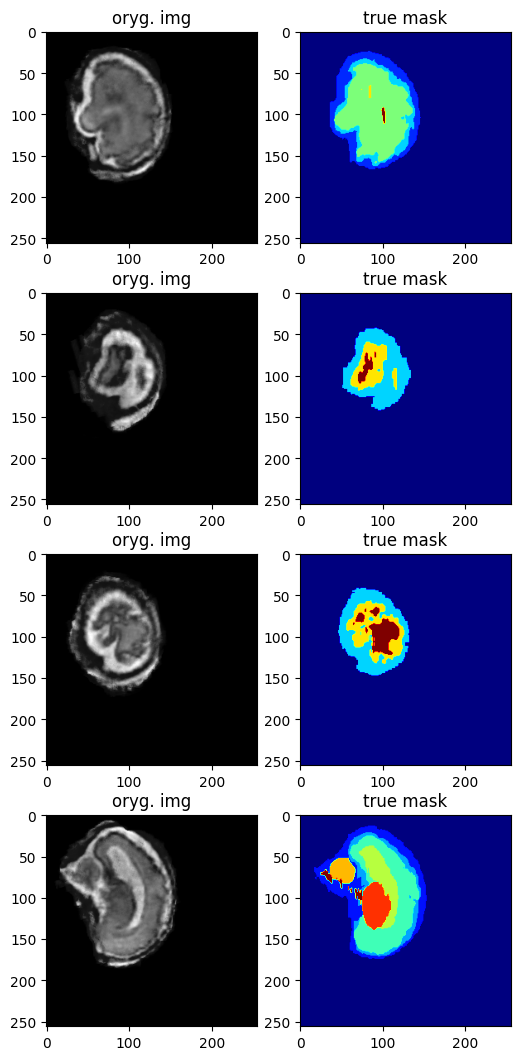

In [31]:
loader = load_BrainTissue_data(configs.DATA_2D_PATH, 1, 1, 'X', None, 4)
X, Y = next(iter(loader))

X.shape # batchsize, channels, width, height, tensors in range [0.0, 1.0]
Y.shape # batchsize, width, height, asks in range {0, 1, ..., 7}

imgs = list(X)
masks = list(Y)

imgs = [scale_array_to_range(img.numpy().squeeze(), 0, 1, 0, 255) for img in imgs]
masks = [mask.numpy() for mask in masks]

plot_imgs_and_masks(imgs, masks)